In [1]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

import pandas as pd 

path = 'Data' # Path of the dataset folder
df_feeds = pd.read_csv(path + '/train/train_data_feeds.csv')
df_ads = pd.read_csv(path + '/train/train_data_ads.csv')
user_ads = df_ads['user_id'].unique()
df_pot = df_feeds[df_feeds['u_userId'].isin(user_ads)]
df_nonpot = df_feeds.drop(df_pot.index)

In [2]:
df_nonpot.columns

Index(['u_userId', 'u_phonePrice', 'u_browserLifeCycle', 'u_browserMode',
       'u_feedLifeCycle', 'u_refreshTimes', 'u_newsCatInterests',
       'u_newsCatDislike', 'u_newsCatInterestsST', 'u_click_ca2_news',
       'i_docId', 'i_s_sourceId', 'i_regionEntity', 'i_cat', 'i_entities',
       'i_dislikeTimes', 'i_upTimes', 'i_dtype', 'e_ch', 'e_m', 'e_po', 'e_pl',
       'e_rn', 'e_section', 'e_et', 'label', 'cillabel', 'pro'],
      dtype='object')

In [3]:
import numpy as np
# Importing the NumPy library, which provides support for large, multi-dimensional arrays and matrices,
# along with a large collection of high-level mathematical functions to operate on these arrays.

columns_to_drop = [column for column in df_nonpot.columns if df_nonpot[column].nunique() > 1000 or df_nonpot[column].nunique() == 1]
# Constructing a list of columns from the dataframe 'df_task' to be dropped.
# A column is added to this list if it has more than 1000 unique values, which typically
# suggests that the column contains highly granular data, possibly not useful for analysis
# or could lead to issues like overfitting if used in machine learning models.

df_nonpot = df_nonpot.drop(columns=columns_to_drop)
# Removing the columns identified in the 'columns_to_drop' list from 'df_task'.
# This operation simplifies the dataframe by excluding columns with excessive uniqueness.

df_nonpot = df_nonpot.select_dtypes(include=[np.number])
# Filtering the dataframe to include only columns that have numerical data types.
# This step is crucial for analyses that require numerical inputs, such as mathematical
# operations or statistical modeling.

print(df_nonpot.shape)
print(df_nonpot.dtypes)
print(df_nonpot.nunique())

(751889, 18)
u_phonePrice          int64
u_browserLifeCycle    int64
u_browserMode         int64
u_feedLifeCycle       int64
u_refreshTimes        int64
i_regionEntity        int64
i_cat                 int64
i_dislikeTimes        int64
i_upTimes             int64
i_dtype               int64
e_ch                  int64
e_m                   int64
e_po                  int64
e_rn                  int64
e_section             int64
label                 int64
cillabel              int64
pro                   int64
dtype: object
u_phonePrice            7
u_browserLifeCycle      8
u_browserMode           8
u_feedLifeCycle         8
u_refreshTimes         10
i_regionEntity        364
i_cat                 207
i_dislikeTimes         10
i_upTimes              10
i_dtype                 5
e_ch                   19
e_m                   262
e_po                   27
e_rn                   99
e_section               2
label                   2
cillabel                2
pro                    35
d

In [4]:
df_nonpot['label'] = df_nonpot['label'].replace({-1:0, 1:1})
df_nonpot['cillabel'] = df_nonpot['cillabel'].replace({-1:0, 1:1})

In [5]:
from Dataset_Utility.utility_functions import calculate_label_rate2
calculate_label_rate2(df_nonpot, 'cillabel')

sample = df_nonpot.sample(frac = 0.1, random_state=10)
calculate_label_rate2(sample, 'cillabel')

Total Sample size is 751889, Positive Sample size is 170, Negative Sample size is 751719, label rate is 0.0002
Total Sample size is 75189, Positive Sample size is 18, Negative Sample size is 75171, label rate is 0.0002


In [6]:
y = sample['cillabel']
X = sample.drop('cillabel', axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=14)

In [8]:
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.00023820867079561695
0.00024180872929512756


In [9]:
features = [f"Feature {i}" for i in range(X_train.shape[1])]

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


models = {
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(random_state=0, probability=True),
    'RF': RandomForestClassifier(random_state=0),    
    'XGB': XGBClassifier()
}

In [12]:
pd.DataFrame({'Feature':features, 'Name':X.columns})

,Feature,Name
0,Feature 0,u_phonePrice
1,Feature 1,u_browserLifeCycle
2,Feature 2,u_browserMode
3,Feature 3,u_feedLifeCycle
4,Feature 4,u_refreshTimes
5,Feature 5,i_regionEntity
6,Feature 6,i_cat
7,Feature 7,i_dislikeTimes
8,Feature 8,i_upTimes
9,Feature 9,i_dtype


# Random Forest Feature Importance

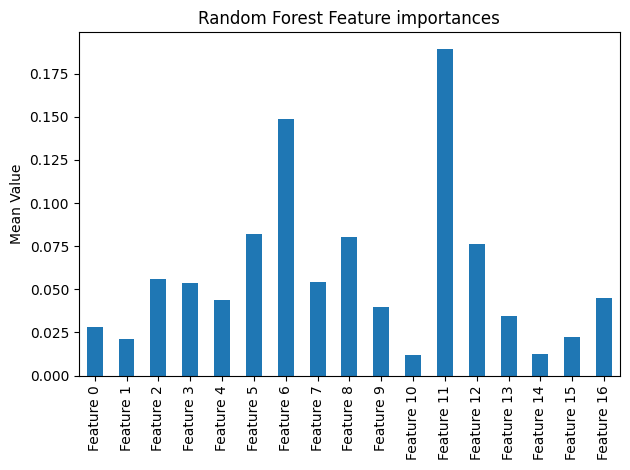

In [13]:
import matplotlib.pyplot as plt
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest Feature importances")
ax.set_ylabel("Mean Value")
fig.tight_layout()

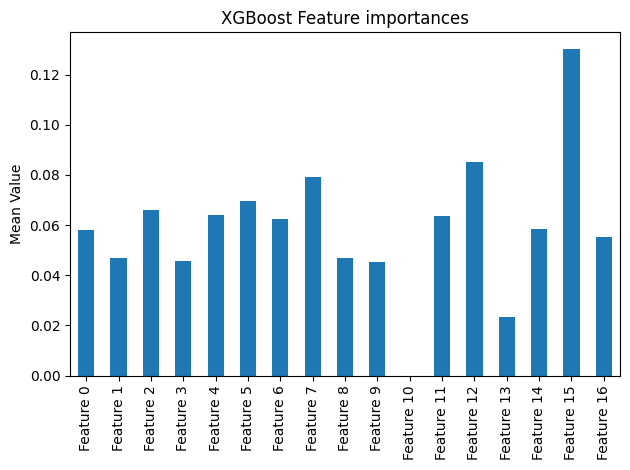

In [14]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
importances = XGB.feature_importances_
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("XGBoost Feature importances")
ax.set_ylabel("Mean Value")
fig.tight_layout()

# Permutation Feature Importance and SHAP Value

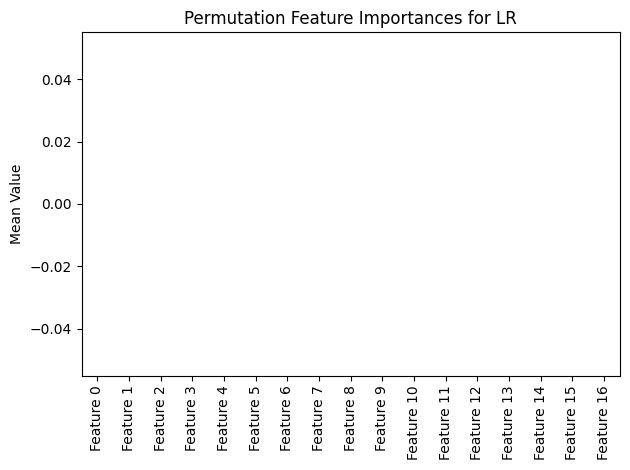

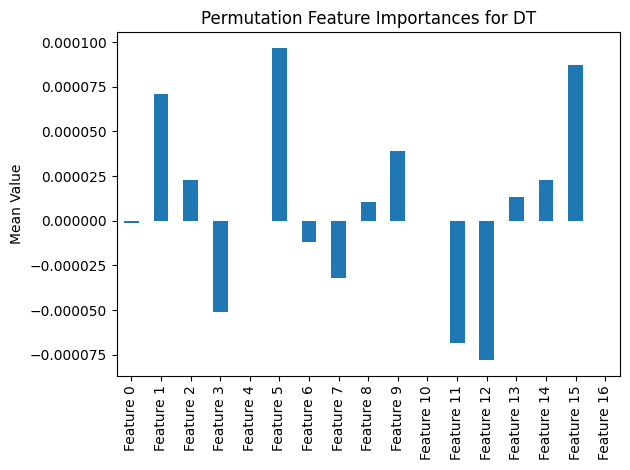

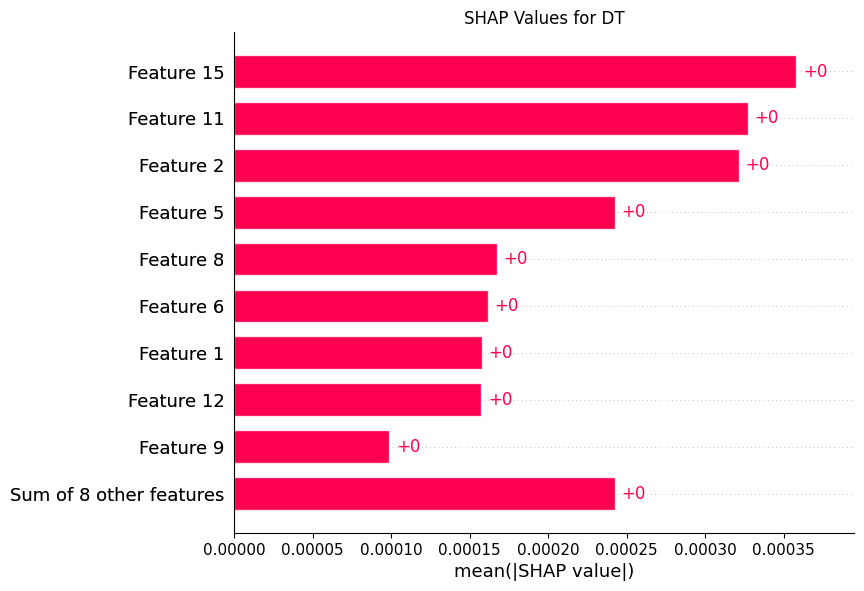

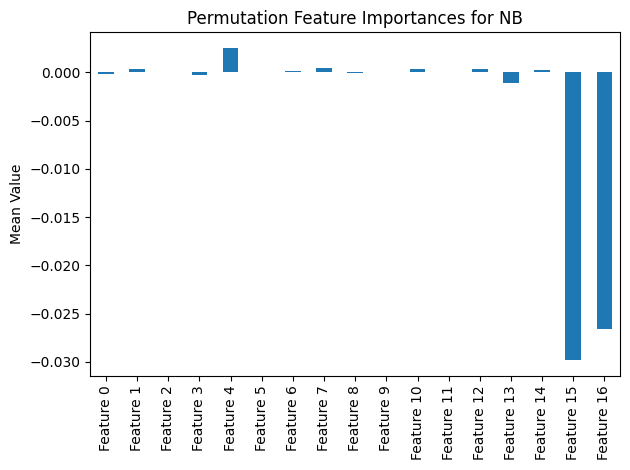

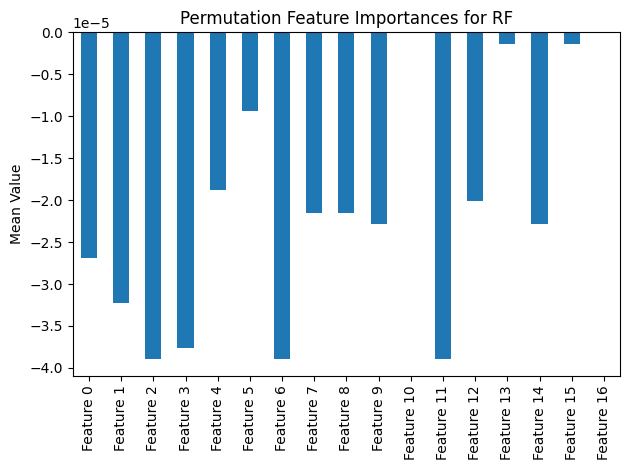

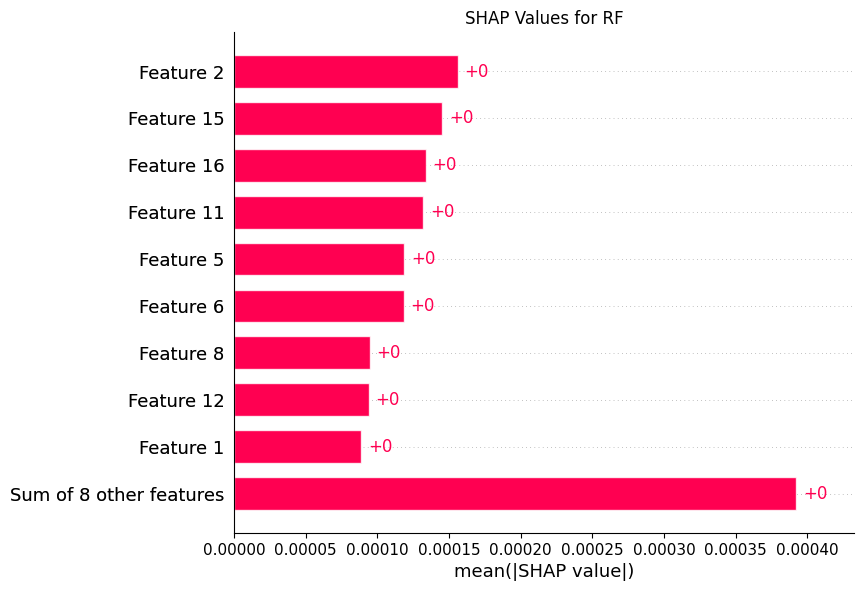

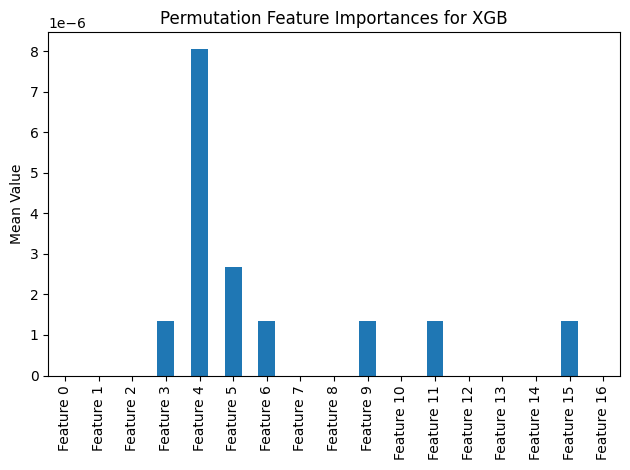

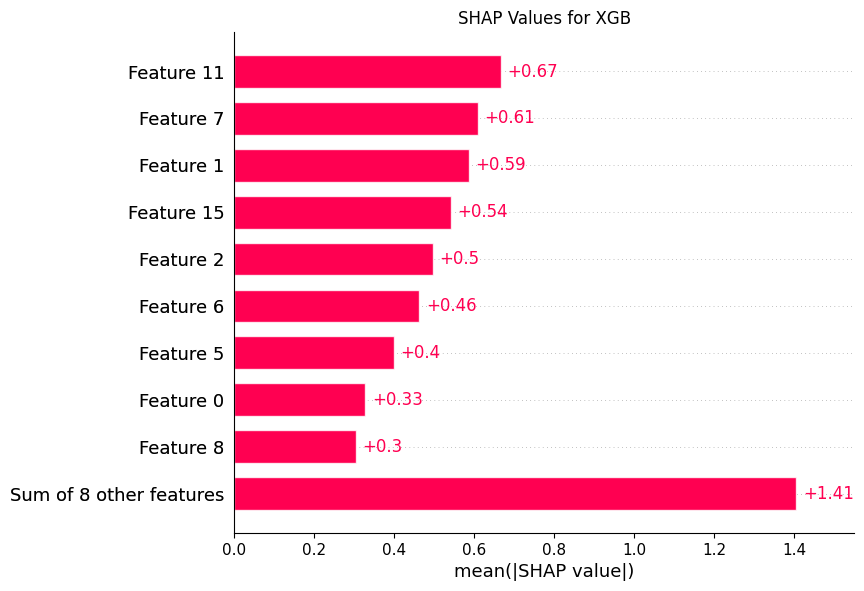

In [15]:
from sklearn.inspection import permutation_importance
import shap

models = {    
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(random_state=0),
    #'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    #'SVM': SVC(random_state=0, probability=True),
    'RF': RandomForestClassifier(random_state=0),    
    'XGB': XGBClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
    globals()[f'per_imp_{name}'] = r
    permutation_importances = pd.Series(r.importances_mean, index=features)
    fig, ax = plt.subplots()
    permutation_importances.plot.bar(ax=ax)
    ax.set_title(f"Permutation Feature Importances for {name}")
    ax.set_ylabel("Mean Value")
    fig.tight_layout()
    plt.show()
    plt.close()
    
    
    if name == "XGB":
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        globals()[f'shap_imp_{name}'] = shap_values    
        shap.plots.bar(shap_values, show=False)
        plt.title(f"SHAP Values for {name}")
        plt.show()
        plt.close()
    elif name == "DT" or name == "RF":
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)[:,:,1]
        globals()[f'shap_imp_{name}'] = shap_values    
        shap.plots.bar(shap_values, show=False)
        plt.title(f"SHAP Values for {name}")
        plt.show()
        plt.close()      

In [ ]:
from sklearn.inspection import permutation_importance
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
r = permutation_importance(KNN, X_test, y_test, n_repeats=30, random_state=0)
per_imp_KNN = r
permutation_importances = pd.Series(r.importances_mean, index=features)
fig, ax = plt.subplots()
permutation_importances.plot.bar(ax=ax)
ax.set_title("Permutation Feature importances for KNN")
ax.set_ylabel("Mean Value")
fig.tight_layout()
plt.show()
plt.close()

In [24]:
from sklearn.inspection import permutation_importance
SVM = SVC(random_state=0, probability=True)
SVM.fit(X_train,y_train)
r = permutation_importance(SVM, X_test, y_test, n_repeats=30, random_state=0)
per_imp_SVM = r
permutation_importances = pd.Series(r.importances_mean, index=features)
fig, ax = plt.subplots()
permutation_importances.plot.bar(ax=ax)
ax.set_title("Permutation Feature importances for SVM")
ax.set_ylabel("Mean Value")
fig.tight_layout()
plt.show()
plt.close()


KeyboardInterrupt



# Permutation Feature Importance

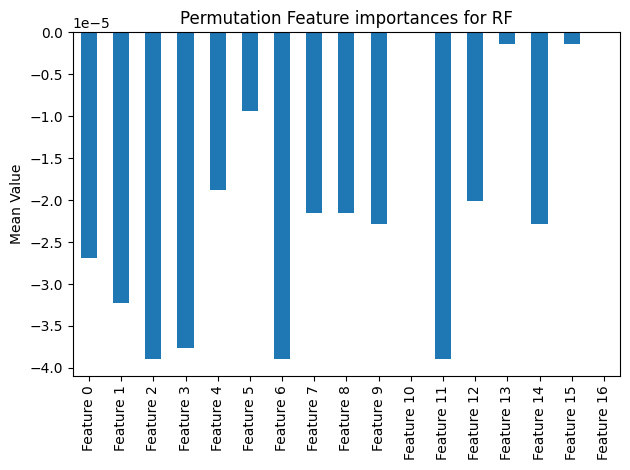

In [16]:
from sklearn.inspection import permutation_importance

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train,y_train)
r = permutation_importance(forest, X_test, y_test, n_repeats=30, random_state=0)
permutation_importances = pd.Series(r.importances_mean, index=features)
fig, ax = plt.subplots()
permutation_importances.plot.bar(ax=ax)
ax.set_title("Permutation Feature importances for RF")
ax.set_ylabel("Mean Value")
fig.tight_layout()
plt.show()
plt.close()

# SHAP  value Feature Importance 

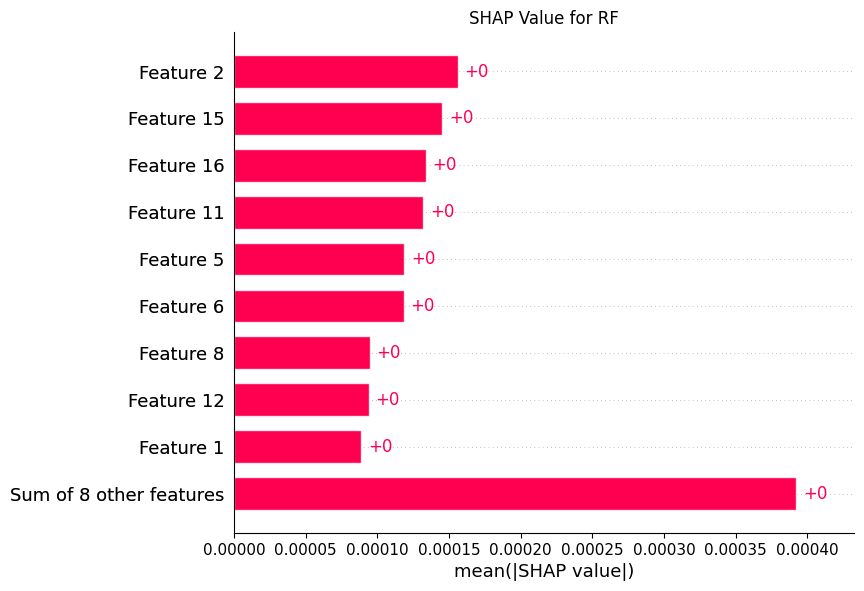

In [17]:
import shap

explainer = shap.Explainer(forest)
y_pred = forest.predict(X_test)
shap_values = explainer(X_test)[:,:,1]
shap.plots.bar(shap_values, show=False)
plt.title(f"SHAP Value for RF")
plt.show()
plt.close()